In [12]:
import h5py
from pathlib import Path
import warnings
import numba
from datetime import datetime
from tensorflow.keras.preprocessing.sequence import pad_sequences
from helper_functions import *
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sktime.classification.feature_based import FreshPRINCE
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.classification.interval_based import DrCIF
from sktime.classification.dictionary_based import TemporalDictionaryEnsemble
from sktime.classification.deep_learning import InceptionTimeClassifier
from sktime.classification.distance_based import ShapeDTW
from sktime.classification.hybrid import HIVECOTEV2
import matplotlib.pyplot as plt
import joblib
import numpy as np
from sklearn.metrics import accuracy_score
from sktime.classification.dummy import DummyClassifier
warnings.filterwarnings('ignore')

In [14]:
LEARNER_ZOO = {0: 'SVC_linear', 1: 'SVC_poly', 2: 'SVC_rbf', 3: 'SVC_sigmoid', 4: 'Decision Trees', 5: 'ExtraTrees', 6: 'LogisticRegression', 7: 'PassiveAggressive', 8: 'Perceptron', 9: 'RidgeClassifier', 10: 'SGDClassifier', 11: 'MLP', 12: 'LDA', 13: 'QDA', 14: 'BernoulliNB', 15: 'MultinomialNB', 16: 'ComplementNB', 17: 'GaussianNB', 18: 'KNN', 19: 'NearestCentroid', 20: 'ens.ExtraTrees', 21: 'ens.RandomForest', 22: 'ens.GradientBoosting', 23: 'DummyClassifier'}

In [15]:
data_path = Path.cwd() / 'dataset/LCDB11_ACC_265_noFS_raw_compress.hdf5'
with h5py.File(data_path, 'r') as f:
    train_raw = np.nanmean(f['accuracy'][...][:,:,:,:,:,0], axis=(2, 3))
    valid_raw = np.nanmean(f['accuracy'][...][:,:,:,:,:,1], axis=(2, 3))
    test_raw  = np.nanmean(f['accuracy'][...][:,:,:,:,:,2], axis=(2, 3))

# flatten
train_curves = train_raw.reshape(-1, train_raw.shape[-1])
valid_curves = valid_raw.reshape(-1, valid_raw.shape[-1])
test_curves  = test_raw.reshape(-1,  test_raw.shape[-1])

# labels
labels = np.tile(np.arange(24), 265)

train_curves.shape, valid_curves.shape, test_curves.shape, labels.shape

((6360, 137), (6360, 137), (6360, 137), (6360,))

In [16]:
group_definitions = {
    0: ['Perceptron', 'PassiveAggressive', 'SGDClassifier', 'SVC_linear'],
    1: ['Decision Tree', 'ExtraTree', 'MLP'],
    2: ['SVC_poly', 'SVC_rbf', 'ens.ExtraTrees', 'ens.RandomForest', 'KNN'],
    3: ['MultinomialNB', 'ComplementNB', 'NearestCentroid', 'GaussianNB', 'BernoulliNB'],
    4: ['RidgeClassifier', 'LogisticRegression', 'LDA'],
    5: ['DummyClassifier', 'SVC_sigmoid', 'QDA', 'ens.GradientBoosting'],
}

filtered_train_curves, filtered_valid_curves, filtered_test_curves, learner_ids, group_ids = filter_by_group_definitions_together(
    train_curves, valid_curves, test_curves, labels, group_definitions, LEARNER_ZOO
)

len(filtered_train_curves), len(filtered_valid_curves), len(filtered_test_curves), learner_ids.shape, group_ids.shape

(5830, 5830, 5830, (5830,), (5830,))

In [17]:
cleaned_train, cleaned_valid, cleaned_test, cleaned_labels = clean_curves_together(
    filtered_train_curves, filtered_valid_curves, 
    filtered_test_curves, group_ids, 
    min_length=50,
)

# find max length among all three splits
MAX_LEN = max(
    max((len(seq) for seq in cleaned_train), default=0),
    max((len(seq) for seq in cleaned_valid), default=0),
    max((len(seq) for seq in cleaned_test),  default=0)
)

# pad each split separately
padded_train = pad_sequences(cleaned_train, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')
padded_valid = pad_sequences(cleaned_valid, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')


# concatenate train and validation curves
train_valid = np.concatenate([padded_train, padded_valid], axis=1)

train_valid.shape, padded_valid.shape, padded_train.shape, cleaned_labels.shape

((3853, 266), (3853, 133), (3853, 133), (3853,))

In [18]:
X = train_valid[:, np.newaxis, :]
y = cleaned_labels

X = X.astype(np.float64)

X.shape, y.shape

((3853, 1, 266), (3853,))

In [21]:
clf = DummyClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv)

joblib.dump(clf, f'trained_models/experiment-model-comparisons/dummy_clf.joblib')
joblib.dump(scores, f'scores/experiment-model-comparisons/dummy_scores.joblib')

print(f"Accuracy: {scores.mean()} +- {scores.std()}")

Accuracy: 0.23566055215860665 +- 0.0006284009347280124


In [8]:
clf = RocketClassifier(rocket_transform='multirocket', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv)

joblib.dump(clf, f'trained_models/experiment-model-comparisons/multirocket_clf.joblib')
joblib.dump(scores, f'scores/experiment-model-comparisons/multirocket_scores.joblib')

print(f"Accuracy: {scores.mean()} +- {scores.std()}")

Accuracy: 0.784326309229033 +- 0.013683894041613366


In [9]:
clf = RocketClassifier(rocket_transform='minirocket', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv)

joblib.dump(clf, f'trained_models/experiment-model-comparisons/minirocket_clf.joblib')
joblib.dump(scores, f'scores/experiment-model-comparisons/minirocket_scores.joblib')

print(f"Accuracy: {scores.mean()} +- {scores.std()}")

Accuracy: 0.712176461670625 +- 0.014097009864152379


In [10]:
clf = RocketClassifier(rocket_transform='rocket', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv)

joblib.dump(clf, f'trained_models/experiment-model-comparisons/rocket_clf.joblib')
joblib.dump(scores, f'scores/experiment-model-comparisons/rocket_scores.joblib')

print(f"Accuracy: {scores.mean()} +- {scores.std()}")

Accuracy: 0.6563757643135075 +- 0.012858437200842156


In [24]:
clf = ShapeletTransformClassifier(n_jobs=-1, transform_limit_in_minutes=120, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv)

joblib.dump(clf, f'trained_models/experiment-model-comparisons/stc_clf.joblib')
joblib.dump(scores, f'scores/experiment-model-comparisons/stc_scores.joblib')

print(f"Accuracy: {scores.mean()} +- {scores.std()}")

Accuracy: 0.6921869051830141 +- 0.015015374565033577


In [20]:
clf = DrCIF(n_estimators=500, n_jobs=-1, time_limit_in_minutes=240, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv)

joblib.dump(clf, f'trained_models/experiment-model-comparisons/drcif_clf.joblib')
joblib.dump(scores, f'scores/experiment-model-comparisons/drcif_scores.joblib')

print(f"Accuracy: {scores.mean()} +- {scores.std()}")

/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and wil

Accuracy: 0.674283019185743 +- 0.01317589862032513


In [26]:
clf = TemporalDictionaryEnsemble(time_limit_in_minutes=240, n_jobs=4, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv)

joblib.dump(clf, f'trained_models/experiment-model-comparisons/tde_clf.joblib')
joblib.dump(scores, f'scores/experiment-model-comparisons/tde_scores.joblib')

print(f"Accuracy: {scores.mean()} +- {scores.std()}")

/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:34: 

Accuracy: 0.5637172166355044 +- 0.0015285027884966848


In [23]:
clf = ShapeDTW()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv)

joblib.dump(clf, f'trained_models/experiment-model-comparisons/tde_clf.joblib')
joblib.dump(scores, f'scores/experiment-model-comparisons/tde_scores.joblib')

print(f"Accuracy: {scores.mean()} +- {scores.std()}")

Accuracy: 0.5338669631276635 +- 0.009465187790030088


In [21]:
clf = InceptionTimeClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv)

joblib.dump(clf, f'trained_models/experiment-model-comparisons/inception_clf.joblib')
joblib.dump(scores, f'scores/experiment-model-comparisons/inception_scores.joblib')

print(f"Accuracy: {scores.mean()} +- {scores.std()}")

2025-06-06 11:37:27.276230: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-06 11:37:27.276840: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-06 11:37:27.276851: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-06 11:37:27.276899: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-06 11:37:27.276951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-06-06 11:37:30.644550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 429ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 544ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 710ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 539ms/step
Accuracy: 0.6452106389071369 +- 0.03618254302003108


In [11]:
clf = FreshPRINCE(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv)

joblib.dump(clf, f'trained_models/experiment-model-comparisons/freshprince_clf.joblib')
joblib.dump(scores, f'scores/experiment-model-comparisons/freshprince_scores.joblib')

print(f"Accuracy: {scores.mean()} +- {scores.std()}")

Accuracy: 0.7269695285259489 +- 0.019876824190463993


In [29]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(cv.split(X, y))

In [30]:
train_idx, test_idx = splits[0]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]


start = datetime.now()
print(f"Fold 0 started at: {start.strftime('%H:%M:%S')}")

clf = HIVECOTEV2(time_limit_in_minutes=720, n_jobs=4, verbose=1, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

end = datetime.now()
print(f"Fold 0 finished at: {end.strftime('%H:%M:%S')}")
print(f"Accuracy: {acc:.4f}")

joblib.dump(clf, "trained_models/experiment-model-comparisons/hc2_fold0.joblib")
joblib.dump(acc, "scores/experiment-model-comparisons/hc2_acc0.joblib")

Fold 0 started at: 13:49:07
STC  15:35:48 09/06/2025
STC train estimate  16:44:35 09/06/2025
STC weight = 0.2255732060156206


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and wil

DrCIF  18:45:28 09/06/2025


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/s

DrCIF train estimate  20:23:31 09/06/2025
DrCIF weight = 0.24530571739759227
Arsenal  20:34:31 09/06/2025
Arsenal train estimate  20:39:32 09/06/2025
Arsenal weight = 0.20546689912012187


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:34: 

TDE  22:40:11 09/06/2025
TDE train estimate  22:40:11 09/06/2025
TDE weight = 0.09973808220110507


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and wil

Fold 0 finished at: 01:55:45
Accuracy: 0.6913


['scores/experiment-model-comparisons/hc2_acc0.joblib']

In [31]:
train_idx, test_idx = splits[1]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]


start = datetime.now()
print(f"Fold 1 started at: {start.strftime('%H:%M:%S')}")

clf = HIVECOTEV2(time_limit_in_minutes=720, n_jobs=4, verbose=1, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

end = datetime.now()
print(f"Fold 1 finished at: {end.strftime('%H:%M:%S')}")
print(f"Accuracy: {acc:.4f}")

joblib.dump(clf, "trained_models/experiment-model-comparisons/hc2_fold1.joblib")
joblib.dump(acc, "scores/experiment-model-comparisons/hc2_acc1.joblib")

Fold 1 started at: 02:00:38
STC  03:47:16 10/06/2025
STC train estimate  04:54:15 10/06/2025
STC weight = 0.2302825234923442


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and wil

DrCIF  06:55:01 10/06/2025


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/s

DrCIF train estimate  08:36:42 10/06/2025
DrCIF weight = 0.25170068953822866
Arsenal  08:47:16 10/06/2025
Arsenal train estimate  08:51:54 10/06/2025
Arsenal weight = 0.20546689912012187


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:34: 

TDE  10:53:43 10/06/2025
TDE train estimate  10:53:43 10/06/2025
TDE weight = 0.09950793962097207


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and wil

Fold 1 finished at: 14:09:54
Accuracy: 0.6913


['scores/experiment-model-comparisons/hc2_acc1.joblib']

In [32]:
train_idx, test_idx = splits[2]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]


start = datetime.now()
print(f"Fold 2 started at: {start.strftime('%H:%M:%S')}")

clf = HIVECOTEV2(time_limit_in_minutes=720, n_jobs=4, verbose=1, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

end = datetime.now()
print(f"Fold 2 finished at: {end.strftime('%H:%M:%S')}")
print(f"Accuracy: {acc:.4f}")

joblib.dump(clf, "trained_models/experiment-model-comparisons/hc2_fold2.joblib")
joblib.dump(acc, "scores/experiment-model-comparisons/hc2_acc2.joblib")

Fold 1 started at: 14:15:06
STC  16:01:02 10/06/2025
STC train estimate  17:01:21 10/06/2025
STC weight = 0.22514869762974665


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and wil

DrCIF  19:02:05 10/06/2025


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/s

DrCIF train estimate  20:47:35 10/06/2025
DrCIF weight = 0.24848777455513005
Arsenal  20:58:58 10/06/2025
Arsenal train estimate  21:03:47 10/06/2025
Arsenal weight = 0.2015346318903789


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:34: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  d[key] = value
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:34: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  d[key] = value
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: 

TDE  23:05:04 10/06/2025
TDE train estimate  23:05:04 10/06/2025
TDE weight = 0.1078033506531458


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and wil

Fold 2 finished at: 02:06:55
Accuracy: 0.6874


['scores/experiment-model-comparisons/hc2_acc2.joblib']

In [33]:
train_idx, test_idx = splits[3]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]


start = datetime.now()
print(f"Fold 3 started at: {start.strftime('%H:%M:%S')}")

clf = HIVECOTEV2(time_limit_in_minutes=720, n_jobs=4, verbose=1, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

end = datetime.now()
print(f"Fold 3 finished at: {end.strftime('%H:%M:%S')}")
print(f"Accuracy: {acc:.4f}")

joblib.dump(clf, "trained_models/experiment-model-comparisons/hc2_fold3.joblib")
joblib.dump(acc, "scores/experiment-model-comparisons/hc2_acc3.joblib")

Fold 3 started at: 02:12:00
STC  03:58:31 11/06/2025
STC train estimate  05:04:04 11/06/2025
STC weight = 0.23961085095168724


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and wil

DrCIF  07:04:14 11/06/2025


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/s

DrCIF train estimate  08:47:08 11/06/2025
DrCIF weight = 0.2574158261574814
Arsenal  08:57:58 11/06/2025
Arsenal train estimate  09:02:42 11/06/2025
Arsenal weight = 0.20638972576007691


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:34: 

TDE  11:06:25 11/06/2025
TDE train estimate  11:06:25 11/06/2025
TDE weight = 0.09620266028960854


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and wil

Fold 3 finished at: 14:27:28
Accuracy: 0.6857


['scores/experiment-model-comparisons/hc2_acc3.joblib']

In [34]:
train_idx, test_idx = splits[4]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]


start = datetime.now()
print(f"Fold 4 started at: {start.strftime('%H:%M:%S')}")

clf = HIVECOTEV2(time_limit_in_minutes=720, n_jobs=4, verbose=1, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

end = datetime.now()
print(f"Fold 4 finished at: {end.strftime('%H:%M:%S')}")
print(f"Accuracy: {acc:.4f}")

joblib.dump(clf, "trained_models/experiment-model-comparisons/hc2_fold4.joblib")
joblib.dump(acc, "scores/experiment-model-comparisons/hc2_acc4.joblib")

Fold 4 started at: 14:32:30
STC  16:19:46 11/06/2025
STC train estimate  17:48:15 11/06/2025
STC weight = 0.21445088188446598


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and wil

DrCIF  19:48:20 11/06/2025


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/s

DrCIF train estimate  21:06:46 11/06/2025
DrCIF weight = 0.23388643012616753
Arsenal  21:17:26 11/06/2025
Arsenal train estimate  21:21:59 11/06/2025
Arsenal weight = 0.1981723538515254


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:54: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  return d.get(key, default)
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/numba/typed/typeddict.py:34: 

TDE  23:25:25 11/06/2025
TDE train estimate  23:25:25 11/06/2025
TDE weight = 0.09266658437856008


/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and wil

Fold 4 finished at: 02:17:49
Accuracy: 0.7156


['scores/experiment-model-comparisons/hc2_acc4.joblib']

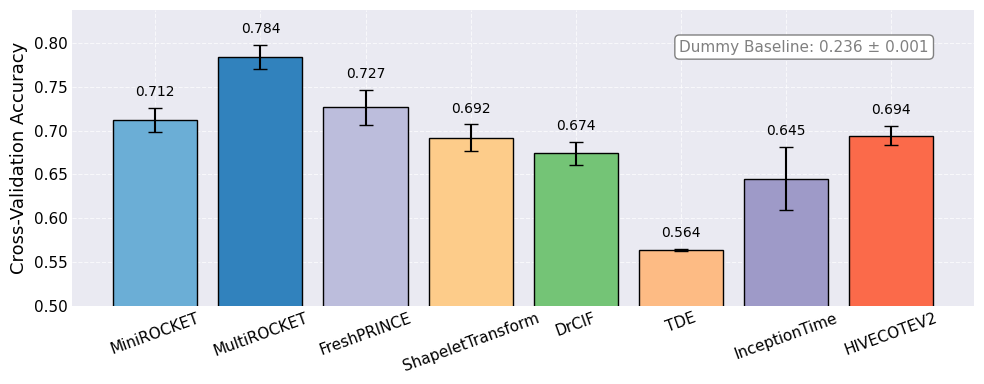

In [45]:
classifier_info = {
    "MiniROCKET": "scores/experiment-model-comparisons/minirocket_scores.joblib",
    "MultiROCKET": "scores/experiment-model-comparisons/multirocket_scores.joblib",
    "FreshPRINCE": "scores/experiment-model-comparisons/freshprince_scores.joblib",
    "ShapeletTransform": "scores/experiment-model-comparisons/stc_scores.joblib",
    "DrCIF": "scores/experiment-model-comparisons/drcif_scores.joblib",
    "TDE": "scores/experiment-model-comparisons/tde_scores.joblib",
    "InceptionTime": "scores/experiment-model-comparisons/inception_scores.joblib",
    "HIVECOTEV2": [f"scores/experiment-model-comparisons/hc2_acc{i}.joblib" for i in range(5)]
}

# load scores
classifier_scores = {}
for name, path in classifier_info.items():
    if isinstance(path, list):  # handle HC2's individual folds
        classifier_scores[name] = np.array([joblib.load(p) for p in path])
    else:
        classifier_scores[name] = joblib.load(path)
        
dummy_scores = joblib.load("scores/experiment-model-comparisons/dummy_scores.joblib")

classifier_colors = {
    "MiniROCKET": "#6baed6",    
    "MultiROCKET": "#3182bd",    
    "FreshPRINCE": "#bcbddc",    
    "ShapeletTransform": "#fdcc8a", 
    "DrCIF": "#74c476",         
    "TDE": "#fdbb84",            
    "InceptionTime": "#9e9ac8", 
    "HIVECOTEV2": "#fb6a4a",     
}

labels = list(classifier_scores.keys())
means = [classifier_scores[clf].mean() for clf in labels]
stds = [classifier_scores[clf].std() for clf in labels]
colors = [classifier_colors[clf] for clf in labels]

plt.rcParams.update({
    'font.size': 12,        
    'axes.titlesize': 12,  
    'axes.labelsize': 13, 
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 12
})

plt.figure(figsize=(10, 4))

ax = plt.gca() 
ax.set_facecolor('#EAEAF2')
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', alpha=0.7, color='white')
ax.tick_params(axis='both', length=0)
for spine in ax.spines.values():
    spine.set_visible(False)

bars = plt.bar(labels, means, yerr=stds, capsize=5, color=colors, edgecolor="black")

# add value labels
for bar, mean, std in zip(bars, means, stds):
    y_pos = mean + std + 0.01  # small padding above the error bar
    plt.text(bar.get_x() + bar.get_width() / 2, y_pos,
             f"{mean:.3f}", ha='center', va='bottom', fontsize=10)
    
ax.text(0.95, 0.90, f"Dummy Baseline: {dummy_scores.mean():.3f} ± {dummy_scores.std():.3f}", transform=ax.transAxes,
        fontsize=11, color='gray', ha='right', va='top',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


plt.ylabel("Cross-Validation Accuracy")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0.5)
plt.tight_layout()
plt.savefig("plots/model-comparison.png", dpi=300)
plt.show()